In [5]:
import torch
import torchhd
import torchhd.functional as HDF
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use(['science', 'nature'])

In [6]:
def bundle(*inputs, normalize=False, auxiliary=None):
    if auxiliary is not None:
        inputs = list(inputs) + [auxiliary]

    res = torch.vstack(inputs).sum(-2)

    if normalize:
        res = torch.where(res > 0, 1.0, -1.0)

    return res

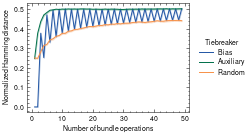

In [7]:
dim = 10000
max_bundles = 50
bundle_step = 1
repeats = 10
auxiliary = HDF.random_hv(1, dim).view(dim)

data = pd.DataFrame(columns=['operations', 'distance', 'type'])

def distance(a, b):
    return (a != b).sum() / a.size(0)

index_counter = 0
for r in range(repeats):
    x = HDF.random_hv(max_bundles, dim)

    for num_bundles in range(1, max_bundles, bundle_step):
        results = torch.zeros(4, dim)
        for i in range(num_bundles):
            is_last_bundle = i == num_bundles - 1
            results[0] = bundle(results[0], x[i], normalize=is_last_bundle)
            results[1] = bundle(results[1], x[i], normalize=True)
            results[2] = bundle(results[2], x[i], normalize=True, auxiliary=auxiliary)
            results[3] = bundle(results[3], x[i], normalize=True, auxiliary=HDF.random_hv(1, dim).view(dim))

        data.loc[index_counter] = [num_bundles, distance(results[0], results[1]).item(), "Bias"]
        index_counter += 1
        data.loc[index_counter] = [num_bundles, distance(results[0], results[2]).item(), "Auxiliary"]
        index_counter += 1
        data.loc[index_counter] = [num_bundles, distance(results[0], results[3]).item(), "Random"]
        index_counter += 1

plt.figure(figsize=(2.9, 2.0))
ax = sns.lineplot(x="operations", y="distance", hue="type", data=data, palette=["#2659A6", "#04724D", "#F7934C"])
ax.set_xlabel("Number of bundle operations")
ax.set_ylabel("Normalized Hamming distance")
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left", title="Tiebreaker")
plt.savefig("bundle-error.pgf")
plt.savefig("bundle-error.png", dpi=300)
plt.show()